# Modeling Engel outcomes (Multiclass) using clinical data

## Import data

In [1]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\Amaury\AppData\Local\Temp\ipykernel_11284\4254179035.py:4: DtypeWarning: Columns (859,862) have mixed types. Specify dtype option on import or set low_memory=False.
  wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")


## Select features

'sex_gender': 0 represents female and 1 represents male

'age': Age in years

'eeg': number of EEGs per patient

'engel_outcomes': number of Engel outcomes per patient

'mri': number of MRIs per patient

'neuroanatomical_labeling': number of Neuroanatomical labeling per patient

...

In [2]:
# Selecting patients who only went through 1 surgery
wide_df = wide_df[wide_df["surgical_information"]==1]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset_hw", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "freq_per_month_hw", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15", "seizure_notes_word_cnt"]]

epilepsy_diagnosis = ["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "epi_icd", "epi_dx"] # "epi_dx" and "epi_key_information" for term frequency // Hot-encode the rest

X = X.rename(columns={"age_of_onset_hw": "age_of_onset",
                      "freq_per_month_hw": "freq_per_month"})

X = pd.concat([X, wide_df[epilepsy_diagnosis]], axis=1)

# Fill NaN values with an empty string
X['epi_dx'] = X['epi_dx'].fillna('')

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## One-hot encoding

One-hot encode the new columns from Epliepsy diagnosis information

In [3]:
# One-Hot Encoding for the first four columns
one_hot_encoded_df = pd.get_dummies(X, columns=["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se"])

# Convert textual categorical variable to category type
X['epi_icd'] = X['epi_icd'].astype('category')

# One-Hot Encoding for 'epi_icd'
X = one_hot_encoded_df.join(pd.get_dummies(X['epi_icd'], prefix='epi_icd'))

X = X.drop("epi_icd", axis=1)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 577
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sex_gender                  390 non-null    int64  
 1   age                         390 non-null    float64
 2   eeg                         390 non-null    float64
 3   engel_outcomes              390 non-null    float64
 4   mri                         390 non-null    float64
 5   phys_findings               376 non-null    float64
 6   age_of_onset                275 non-null    float64
 7   eo_yrs_postsurg             382 non-null    float64
 8   neuroanatomical_labeling    390 non-null    float64
 9   neuropsychological_testing  390 non-null    float64
 10  surg_stage                  389 non-null    float64
 11  neuro_findings              376 non-null    float64
 12  eo_year_surg                383 non-null    float64
 13  surgical_information        390 non-null

## Correlation matrix

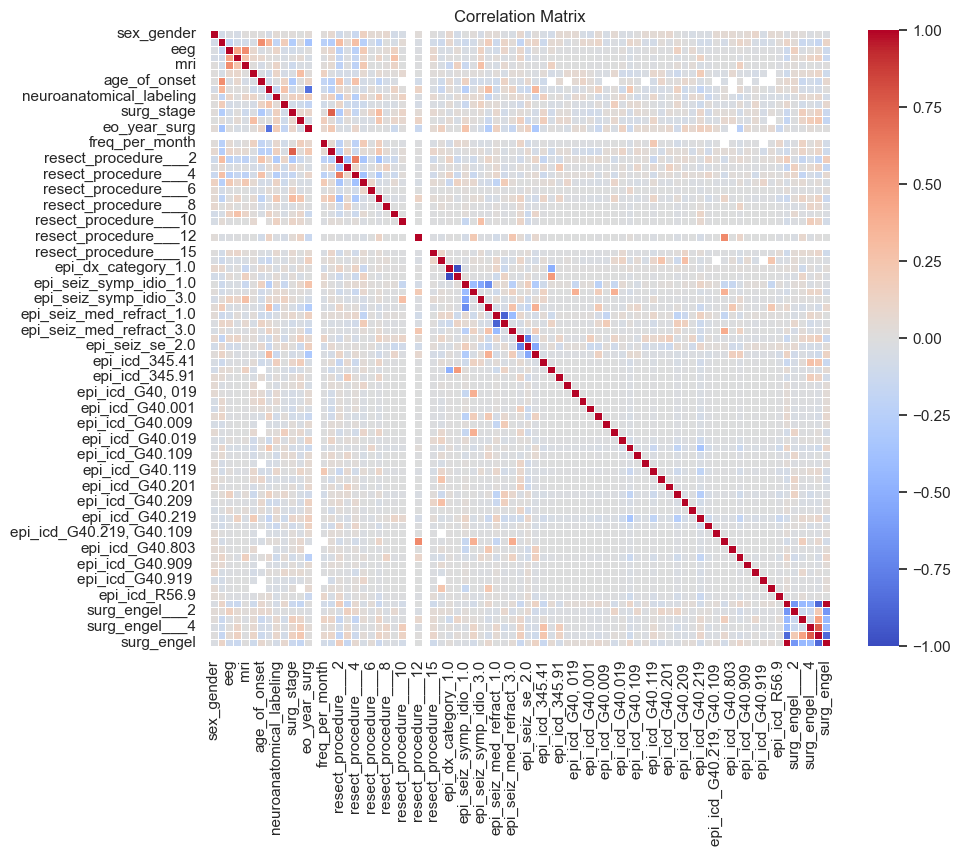

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X.drop("epi_dx", axis=1), engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## Split data into train/test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

Here, we perform SMOTE (Synthetic Minority Over-sampling Technique) to handle the Class Imbalance

In [7]:
#from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import SMOTE
#import pandas as pd

# Create an imputer object with a mean filling strategy
#imputer = SimpleImputer(strategy='median')

# Impute missing values in X_train
#X_train_imputed = imputer.fit_transform(X_train)

# Convert back to DataFrame if X_train was a DataFrame
#X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

# Now apply SMOTE
#smote = SMOTE()
#X_train, y_train = smote.fit_resample(X_train_imputed, y_train)

#X_test_imputed = imputer.transform(X_test)
#X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)

## Term frequency analysis

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Create and fit a CountVectorizer
count_vectorizer = CountVectorizer(binary=True)  # binary=True will set all non-zero counts to 1
count_vectorizer.fit(X_train["epi_dx"])

# Transform the training and test data
X_train_count = count_vectorizer.transform(X_train["epi_dx"])
X_test_count = count_vectorizer.transform(X_test["epi_dx"])

# Convert to DataFrame
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names_out())
X_test_count_df = pd.DataFrame(X_test_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Count non-zero entries for each feature in the training data
non_zero_counts = np.count_nonzero(X_train_count_df, axis=0)

# Create a Series from the counts
non_zero_series = pd.Series(non_zero_counts, index=X_train_count_df.columns)

# Sort the Series in descending order and select top 20
top_20_features = non_zero_series.sort_values(ascending=False).head(20).index

# Select columns from the DataFrames based on top 20 features
X_train_top_20 = X_train_count_df[top_20_features]
X_test_top_20 = X_test_count_df[top_20_features]

# These DataFrames now contain only the top 20 features with 0/1 values
print(X_train_top_20.head())

   epilepsy  partial  with  intractable  seizures  focal  complex  status  \
0         1        0     0            0         0      1        0       0   
1         1        0     1            1         0      0        0       0   
2         0        0     0            0         0      0        0       0   
3         1        1     1            1         1      0        0       1   
4         1        1     0            0         0      0        0       0   

   related  localization  without  epilepticus  symptomatic  of  epileptic  \
0        0             0        0            0            0   0          0   
1        0             0        0            0            0   0          0   
2        0             0        0            0            0   0          1   
3        0             0        1            1            1   0          0   
4        0             0        0            0            0   0          0   

   and  syndromes  consciousness  impairment  not  
0    0          

In [9]:
# Remove the 'seizure_class_notes' column from X_train and X_test
X_train = X_train.drop('epi_dx', axis=1)
X_test = X_test.drop('epi_dx', axis=1)

# Filter out the top 10 TF-IDF features that have the same name as columns in X_train and X_test
common_columns = set(X_train.columns) & set(X_train_top_20.columns)
X_train_top_20_filtered = X_train_top_20.drop(columns=common_columns)
X_test_top_20_filtered = X_test_top_20.drop(columns=common_columns)

# Concatenate the filtered top 10 TF-IDF features with the modified X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_top_20_filtered.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_top_20_filtered.reset_index(drop=True)], axis=1)

## 10-fold cross-validation

By splitting your data into multiple training and validation sets (like in k-fold cross-validation), you can assess the consistency of your model’s performance. Fluctuations in performance across different folds can indicate overfitting, while uniformly poor performance across folds suggests underfitting.

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


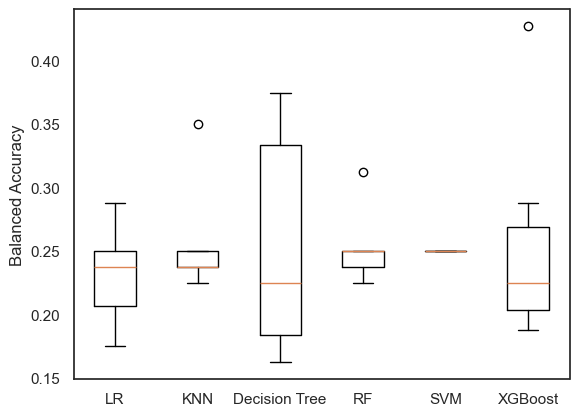

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]
column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='balanced_accuracy')

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())

plt.ylabel('Balanced Accuracy')
plt.show()

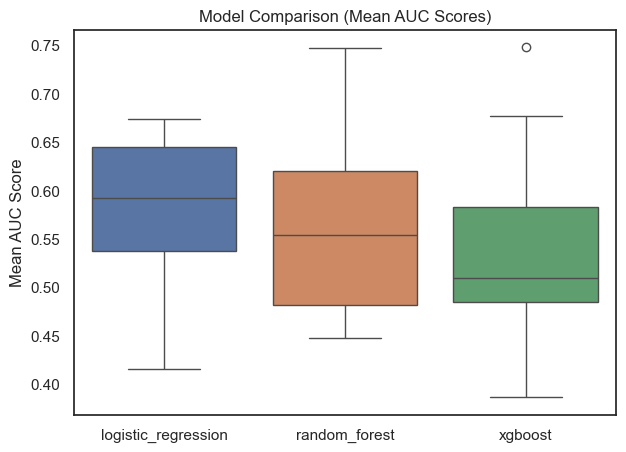

Best Parameters for logistic_regression: [{'model__estimator__C': 0.001}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.01}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.01}, {'model__estimator__C': 0.001}, {'model__estimator__C': 0.001}]
Best Parameters for random_forest: [{'model__estimator__max_depth': 10, 'model__estimator__n_estimators': 20}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 50}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 20}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 20}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 20}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 50}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 20}, {'model__estimator__max_depth': 5, 'model__estimator__n_estimators': 20}, {'model__es

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

X_CV = X_train
y_CV = y_train

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Calculate class weights
#class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_CV), y=y_CV)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define model pipelines with named steps
model_pipelines = {
    'logistic_regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', OneVsRestClassifier(LogisticRegression())) #class_weight=class_weights_dict
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', OneVsRestClassifier(RandomForestClassifier())) #class_weight=class_weights_dict
    ]),
    'xgboost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')))
    ])
}

# Define hyperparameter grids for each model
models_and_parameters = {
    'logistic_regression': {'model__estimator__C': np.logspace(-3, 3, 7)},
    'random_forest': {'model__estimator__n_estimators': [20, 50], 'model__estimator__max_depth': [5, 10]},
    'xgboost': {'model__estimator__n_estimators': [20, 50], 'model__estimator__learning_rate': np.logspace(-3, -1, 3)}
}

# Perform nested cross-validation and store AUC scores
outer_cv = StratifiedKFold(n_splits=10)
inner_cv = StratifiedKFold(n_splits=10)
results = {}
best_params = {}

n_classes = len(np.unique(y_CV))

for model_name, pipeline in model_pipelines.items():
    param_grid = models_and_parameters[model_name]
    mean_auc_scores = []
    params = []

    for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
        X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

        # Binarize the output for multiclass ROC AUC
        y_test_fold_bin = label_binarize(y_test_fold, classes=range(n_classes))

        # Inner CV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc_ovr', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model and parameters
        best_model = grid_search.best_estimator_
        params.append(grid_search.best_params_)

        # Evaluate on test set
        y_pred_proba = best_model.predict_proba(X_test_fold)

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_fold_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute mean AUC
        mean_auc = np.mean(list(roc_auc.values()))
        mean_auc_scores.append(mean_auc)

    results[model_name] = mean_auc_scores
    best_params[model_name] = params

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame(results)

# Plot AUC scores
plt.figure(figsize=(7, 5))
sns.boxplot(data=all_scores)
plt.title('Model Comparison (Mean AUC Scores)')
plt.ylabel('Mean AUC Score')
plt.show()

# Print best parameters
for model in best_params:
    print(f"Best Parameters for {model}: {best_params[model]}")

## Scale continuous variables

In [8]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_test)

# Calculate null accuracy
null_accuracy = accuracy_score(y_test, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")


Null Accuracy: 0.67


## ROC AND AUC

Here we calculate, the Weighted Average AUC Score:

This method computes the average of the metric weighted by the number of true instances for each class. It takes class imbalance into account, which is particularly useful if some classes are underrepresented in the data.

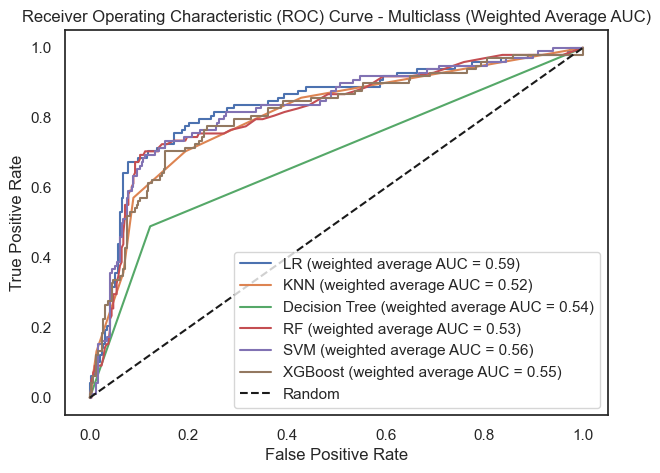

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

# Assuming y_train and y_test are multiclass labels
n_classes = len(np.unique(y_train))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

models = {
    #"Dummy": DummyClassifier(strategy='most_frequent'),
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    # Using OneVsRestClassifier for multiclass classification
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_scaled, y_train_bin)

    # Predict probabilities
    y_pred_prob = clf.predict_proba(X_test_scaled)

    # Compute the weighted average ROC AUC score
    roc_auc_weighted = roc_auc_score(y_test_bin, y_pred_prob, average='weighted', multi_class='ovr')

    # Compute and plot ROC curve for each model
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    plt.plot(fpr, tpr, label=f"{name} (weighted average AUC = {roc_auc_weighted:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - Multiclass (Weighted Average AUC)")
plt.legend(loc="lower right")
plt.show()

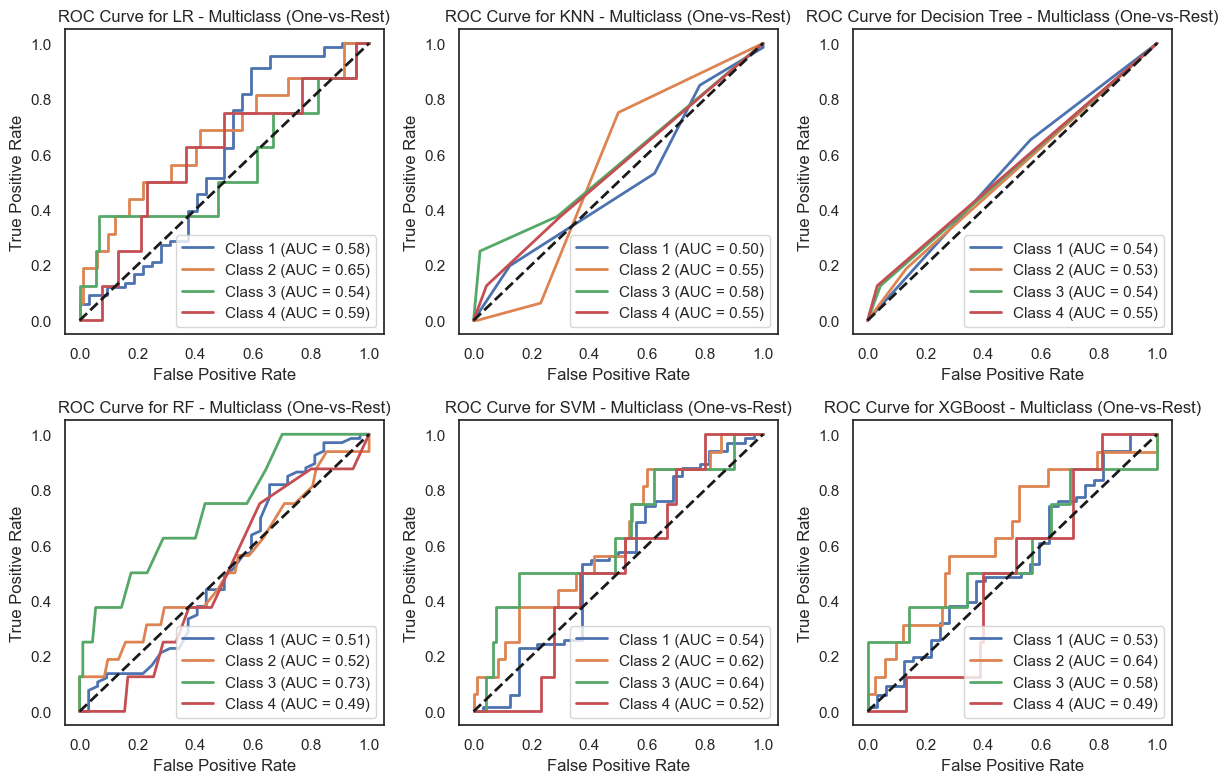

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np

# Assuming y_train and y_test are multiclass labels
n_classes = len(np.unique(y_train))
y_train_bin = label_binarize(y_train, classes=range(n_classes))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, probability=True, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

# Create a 2x3 subplot for different models
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
model_keys = list(models.keys())

# Iterate over models and plot in subplots
for idx, (name, model) in enumerate(models.items()):
    ax = axs[idx // 3, idx % 3]

    clf = OneVsRestClassifier(model)
    clf.fit(X_train_scaled, y_train_bin)
    y_pred_prob = clf.predict_proba(X_test_scaled)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        ax.plot(fpr, tpr, lw=2, label=f'Class {i + 1} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {name} - Multiclass (One-vs-Rest)')
    ax.legend(loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()

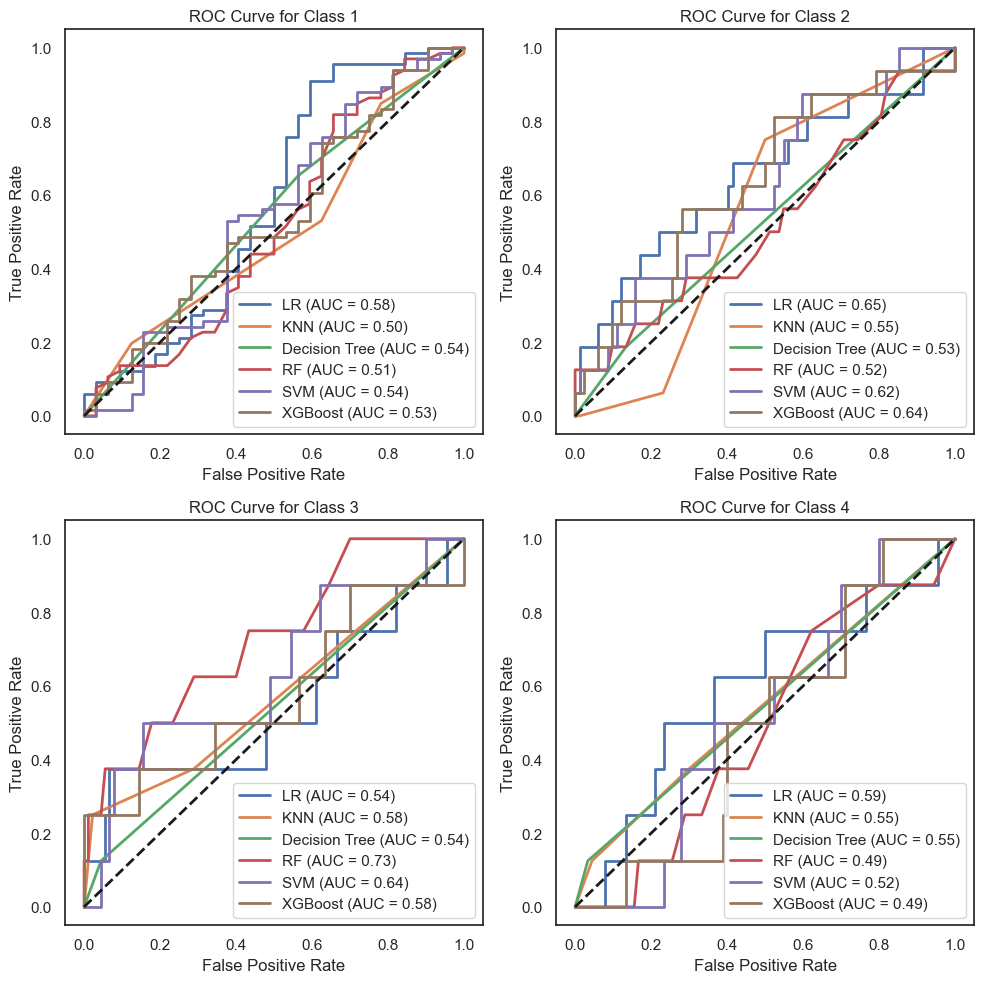

In [12]:
# Pre-training models and storing predictions
model_predictions = {}
for name, model in models.items():
    clf = OneVsRestClassifier(model)
    clf.fit(X_train_scaled, y_train_bin)
    model_predictions[name] = clf.predict_proba(X_test_scaled)

# Creating 2x2 subplot for class-wise ROC curves
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(n_classes):
    ax = axs[i // 2, i % 2]

    for name in models.keys():
        y_pred_prob = model_predictions[name]

        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
        ax.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for Class {i + 1}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier for multiclass prediction
lr = LogisticRegression(max_iter=2000, random_state=42, multi_class='auto')

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.67


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

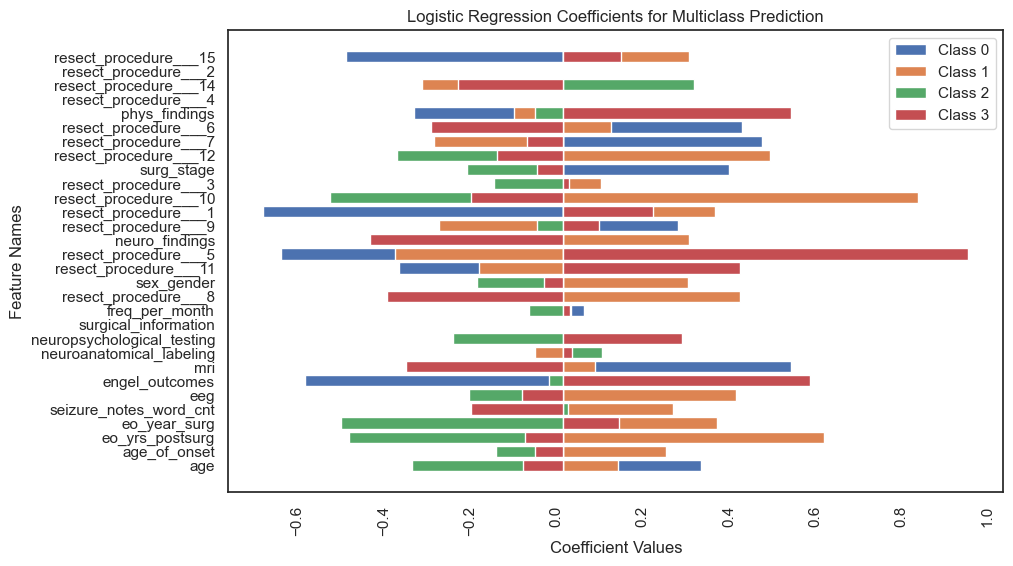

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients and feature names
coefficients = lr.coef_  # This will give you coefficients for each class

# Create a bar plot for each class
plt.figure(figsize=(10, 6))
for class_label in range(len(coefficients)):
    plt.barh(column_names, coefficients[class_label], label=f'Class {class_label}')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients for Multiclass Prediction')
plt.xticks(rotation=90, ha="right")
plt.legend()
plt.show()

In [15]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)

Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(3.0105 + 0.3184 * age + -0.0162 * age_of_onset + -0.0195 * eo_yrs_postsurg + 0.0312 * eo_year_surg + -0.0503 * seizure_notes_word_cnt + -0.0848 * eeg + -0.5996 * engel_outcomes + 0.5278 * mri + -0.0412 * neuroanatomical_labeling + -0.0315 * neuropsychological_testing + 0.0000 * surgical_information + 0.0481 * freq_per_month )))


## Decision Tree classifier

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a Decision Tree Classifier for multiclass prediction
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=100, cv=5, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", random_search.best_params_)

# Use the best model to make predictions
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Evaluate the accuracy, precision, recall, and F1-score of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'entropy'}
Accuracy: 0.64
Precision: 0.46
Recall: 0.64
F1-Score: 0.53


c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Plot decision tree

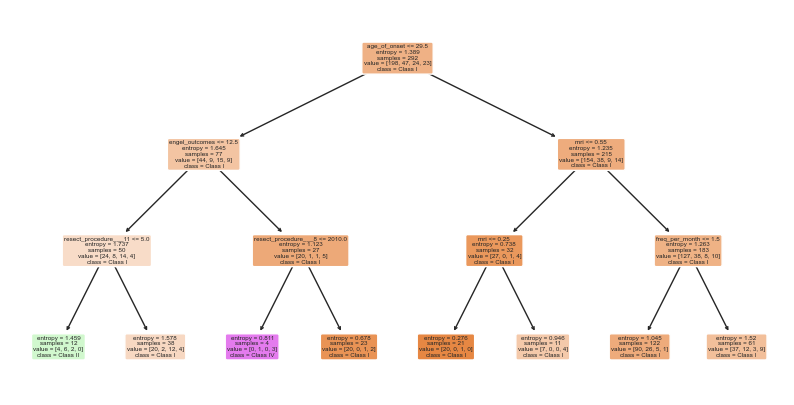

In [18]:
from sklearn.tree import plot_tree

# Define class names for your specific problem (modify as needed)
class_names = ["Class I", "Class II", "Class III", "Class IV"]

# Plot the decision tree
plt.figure(figsize=(10, 5))
plot_tree(best_clf, filled=True, feature_names=column_names, class_names=class_names, rounded=True)
plt.show()


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


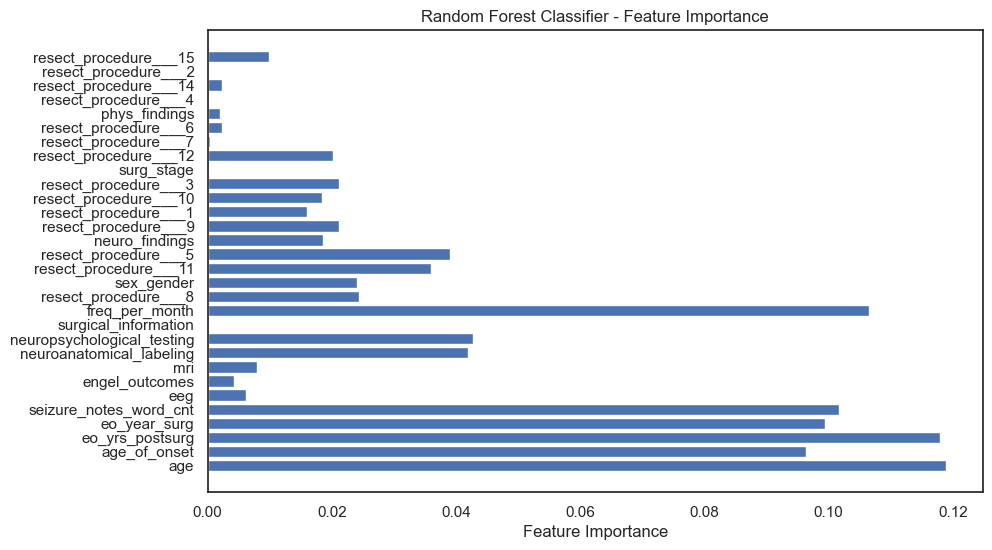

In [20]:
# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

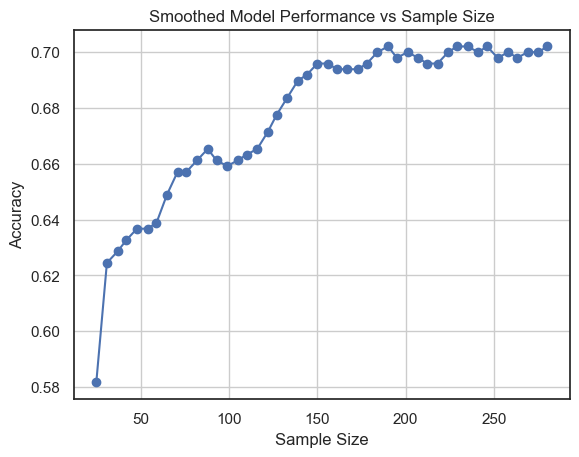

In [21]:
# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Lists to store the results
sample_sizes = []
accuracies = []

# Loop over different sample sizes
for fraction in np.linspace(0.05, 1.0, 50):
    # Determine the sample size
    sample_size = int(fraction * X_train_scaled.shape[0])
    sample_sizes.append(sample_size)

    # Sample the training data
    X_train_sampled = X_train_scaled[:sample_size]
    y_train_sampled = y_train[:sample_size]

    # Train the classifier on the sampled training data
    rf.fit(X_train_sampled, y_train_sampled)

    # Make predictions on the test data
    y_pred = rf.predict(X_test_scaled)

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Applying a simple moving average for smoothing
window_size = 5
smoothed_accuracies = np.convolve(accuracies, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.plot(sample_sizes[int(window_size/2):-int(window_size/2)], smoothed_accuracies, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Accuracy')
plt.title('Smoothed Model Performance vs Sample Size')
plt.grid(True)
plt.show()

## Support Vector Machines (SVM)

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svc = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.69


## XGBoost

In [23]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier for multiclass prediction
xgb = XGBClassifier(objective='multi:softmax', random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


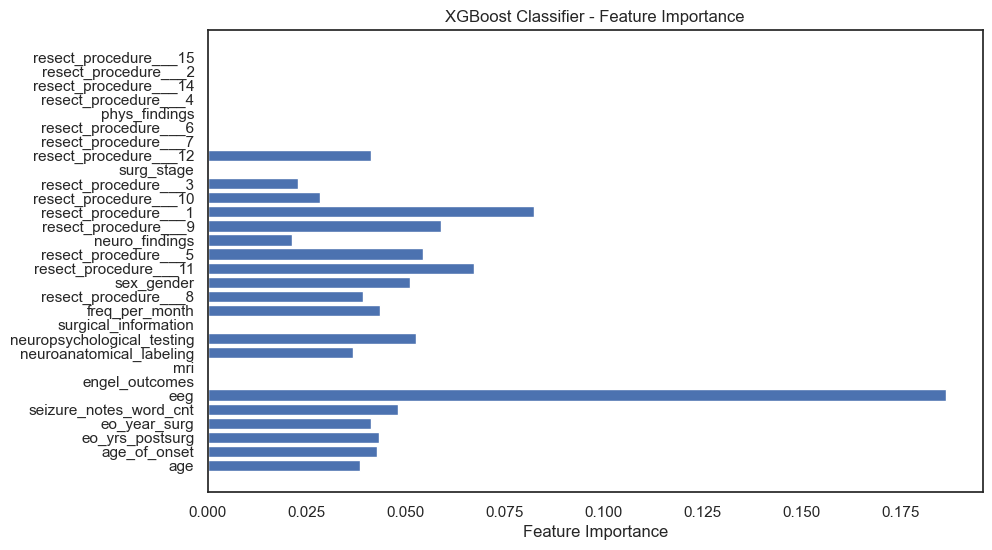

In [24]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [25]:
import tensorflow as tf

# Create a simple neural network model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(set(y_train)), activation='softmax')  # Output layer for multiclass classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=15, batch_size=64, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")





Epoch 1/15


4/4 - 2s - loss: 1.3215 - accuracy: 0.1931 - val_loss: 1.2847 - val_accuracy: 0.1695 - 2s/epoch - 496ms/step
Epoch 2/15
4/4 - 0s - loss: 1.2636 - accuracy: 0.2618 - val_loss: 1.1956 - val_accuracy: 0.4746 - 50ms/epoch - 13ms/step
Epoch 3/15
4/4 - 0s - loss: 1.1920 - accuracy: 0.5107 - val_loss: 1.0949 - val_accuracy: 0.8136 - 75ms/epoch - 19ms/step
Epoch 4/15
4/4 - 0s - loss: 1.1190 - accuracy: 0.6395 - val_loss: 0.9839 - val_accuracy: 0.8136 - 50ms/epoch - 12ms/step
Epoch 5/15
4/4 - 0s - loss: 1.0655 - accuracy: 0.6438 - val_loss: 0.8822 - val_accuracy: 0.8136 - 44ms/epoch - 11ms/step
Epoch 6/15
4/4 - 0s - loss: 1.0359 - accuracy: 0.6438 - val_loss: 0.8160 - val_accuracy: 0.8136 - 50ms/epoch - 12ms/step
Epoch 7/15
4/4 - 0s - loss: 1.0226 - accuracy: 0.6438 - val_loss: 0.7902 - val_accuracy: 0.8136 - 47ms/epoch - 12ms/step
Epoch 8/15
4/4 - 0s - loss: 1.0024 - accuracy: 0.6438 - val_loss: 0.7922 - val_accuracy: 0.8136 - 47ms/epoch - 12ms/step
Epoch 9/15
4/4 - 0s - loss: 

## Perform PCA

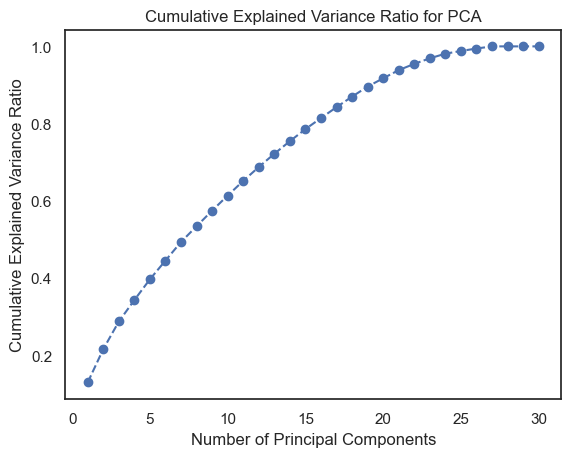

In [26]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [27]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Support Vector Machine
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svc.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Separate features and target
X = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
#y = wide_df[["surg_engel___1", "surg_engel___2", "surg_engel___3", "surg_engel___4"]]
y = wide_df["surg_engel"]

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Now apply SMOTE
#smote = SMOTE()
#X_train, y_train = smote.fit_resample(X_train_imputed, y_train)

# Calculate class weights
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# Data preprocessing (standardization)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_imputed)
#X_test = scaler.transform(X_test_imputed)


model = Sequential()
model.add(Dense(700, activation='relu', input_shape=(X_train_imputed.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(150, activation='relu'))
model.add(Dense(len(set(y_train)), activation='softmax'))  # Adjust according to your output classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
history = model.fit(X_train_imputed, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=2) # class_weight=class_weight_dict

# Evaluate the accuracy of the model
loss, accuracy = model.evaluate(X_test_imputed, y_test)

# Predict probabilities on the test set
y_pred_prob = model.predict(X_test_imputed)

# Calculate AUC for each class and average them
auc_scores = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="weighted")

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Average AUC: {auc_scores:.2f}")

Epoch 1/50
4/4 - 1s - loss: 133.4254 - accuracy: 0.1807 - val_loss: 110.8304 - val_accuracy: 0.0635 - 1s/epoch - 295ms/step
Epoch 2/50
4/4 - 0s - loss: 109.0735 - accuracy: 0.2289 - val_loss: 21.3683 - val_accuracy: 0.6508 - 78ms/epoch - 19ms/step
Epoch 3/50
4/4 - 0s - loss: 87.6569 - accuracy: 0.3092 - val_loss: 33.5364 - val_accuracy: 0.0635 - 75ms/epoch - 19ms/step
Epoch 4/50
4/4 - 0s - loss: 81.5236 - accuracy: 0.1606 - val_loss: 80.4274 - val_accuracy: 0.0635 - 75ms/epoch - 19ms/step
Epoch 5/50
4/4 - 0s - loss: 78.2945 - accuracy: 0.1566 - val_loss: 22.7467 - val_accuracy: 0.0794 - 73ms/epoch - 18ms/step
Epoch 6/50
4/4 - 0s - loss: 58.9694 - accuracy: 0.3012 - val_loss: 7.4028 - val_accuracy: 0.3968 - 75ms/epoch - 19ms/step
Epoch 7/50
4/4 - 0s - loss: 45.0450 - accuracy: 0.3936 - val_loss: 27.2194 - val_accuracy: 0.0794 - 68ms/epoch - 17ms/step
Epoch 8/50
4/4 - 0s - loss: 35.1352 - accuracy: 0.2490 - val_loss: 31.6460 - val_accuracy: 0.1111 - 70ms/epoch - 18ms/step
Epoch 9/50
4/4 

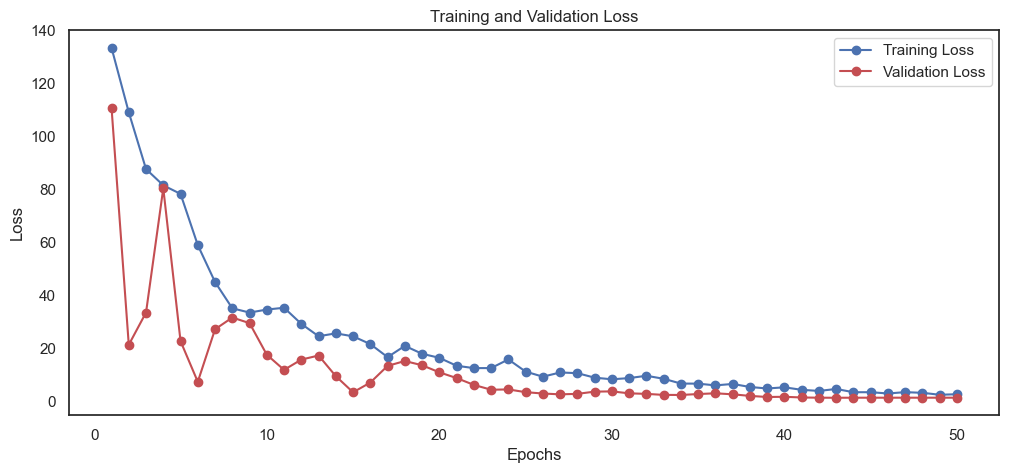

In [29]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))

# Training vs Validation Loss
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3/3 [==============================] - 0s 4ms/step


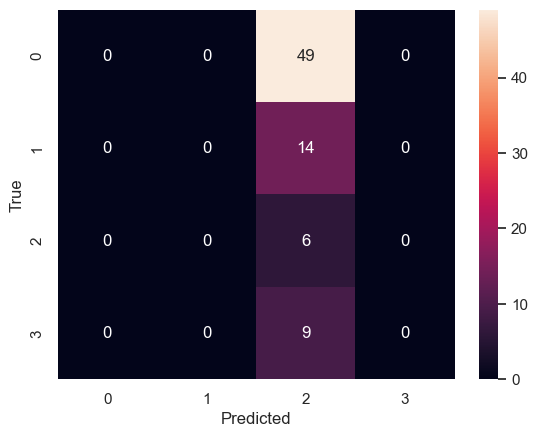

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained model and test data
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)  # If y_test is one-hot encoded
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_labels, y_pred_labels)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Separate features and target
X = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
y = wide_df["surg_engel"] - 1

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train_imputed)
#X_test = scaler.transform(X_test_imputed)

# Define a range of hyperparameters for randomized search
param_distributions = {
    'n_estimators': [300, 400, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [4, 5, 6],
    'subsample': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train_imputed, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
accuracy = best_model.score(X_test_imputed, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

## Print system information

In [32]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'